In [29]:
import torch
import pyro
import random
from umap import UMAP
import matplotlib.pyplot as plt 
import numpy as np

from pyro.distributions import Categorical
from typing import Any, Union, List, Tuple, Dict


def visualize_rbm(rbm, hidden_loader, level, savefig):
    X_train_bin, y_train = hidden_loader.dataset.tensors
    X_train_bin = X_train_bin.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    y_train_input = y_train.reshape(X_train_bin.shape[0], -1) / 10.0 
    X_train_embedded = rbm.transform(X_train_bin, y_train_input)
    umap = UMAP()
    # Fit and transform the data
    X_train_umap = umap.fit_transform(X_train_embedded)
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
    plt.colorbar(scatter, label="Digit Label")
    plt.title("UMAP RBM Embedding of MNIST Training Data of level {}".format(level))
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    # plt.show()
    filename = savefig + "level_" + str(level) + ".png"
    plt.savefig(filename)
    plt.close()
    
def visualize_data(hidden_loader, level, savefig, project=False):
    X_train_bin, y_train = hidden_loader.dataset.tensors
    X_train_embedded = X_train_bin.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    y_train_input = y_train.reshape(X_train_bin.shape[0], -1) / 10.0
    if project:
        X_train_embedded = project_points_to_simplex(X_train_embedded)
        
    # umap = UMAP(n_neighbors=15,
    # min_dist=0.1,
    # metric='euclidean',
    # random_state=42,)
    umap = UMAP()
    # Fit and transform the data
    X_train_umap = umap.fit_transform(X_train_embedded)
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
    plt.colorbar(scatter, label="Digit Label")
    plt.title("UMAP RBM Encoding of MNIST Training Data of level {}".format(level))
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.savefig(savefig)
    plt.show()    
    plt.close()

def project_points_to_simplex(points):
    """
    Projects each point in a multidimensional cube [0, 1]^n onto the n-dimensional simplex.

    Parameters:
        points (np.ndarray): A 2D numpy array where each row is a point in the hypercube [0, 1]^n.

    Returns:
        np.ndarray: A 2D numpy array with each row projected onto the n-dimensional simplex.
    """
    # Number of points and dimension
    num_points, dim = points.shape
    
    # Array to store the projected points
    projected_points = np.zeros_like(points)
    
    for i in range(num_points):
        point = points[i]
        
        # Step 1: Sort the point in descending order
        u = np.sort(point)[::-1]
        
        # Step 2: Find the largest k such that the projection condition holds
        cumulative_sum = np.cumsum(u)
        rho = np.where(u > (cumulative_sum - 1) / (np.arange(dim) + 1))[0][-1]
        
        # Step 3: Compute theta
        theta = (cumulative_sum[rho] - 1) / (rho + 1)
        
        # Step 4: Project point onto the simplex
        projected_points[i] = np.maximum(point - theta, 0)
    
    return projected_points

In [30]:
import numpy as np
import time
from numbers import Integral, Real
import scipy.sparse as sp
from scipy.special import expit, softmax 
import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import BernoulliRBM
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    TransformerMixin,
    _fit_context,
)
from sklearn.utils import check_random_state, gen_even_slices
from sklearn.utils._param_validation import Interval
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import check_is_fitted


class RBM(BernoulliRBM):
    def __init__(self, n_components=2, learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=None, add_bias=False, target_in_model=False, hybrid=False, input_dist='bernoulli', latent_dist='bernoulli',target_dist='gaussian'):
        super().__init__(n_components=n_components, learning_rate=learning_rate,
                         batch_size=batch_size, n_iter=n_iter, verbose=verbose, random_state=random_state)
        self.add_bias = add_bias
        self.input_dist = input_dist # 'bernoulli' or 'gaussian'
        self.latent_dist = latent_dist # 'bernoulli' or 'multinomial'
        self.target_dist = target_dist # 'bernoulli' or 'gaussian'
        self.target_in_model = target_in_model
        self.hybrid = hybrid

    def transform(self, X, y):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self)
        return self._mean_hiddens(X, y)

    def _mean_hiddens(self, v, t):
        """Computes the probabilities P(h=1|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        if (self.input_dist == 'bernoulli'):
            p = safe_sparse_dot(v, self.components_.T)
        elif (self.input_dist == 'gaussian'):
            p = safe_sparse_dot(v/self.sigma, self.components_.T)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        
        if (self.add_bias):
            p += self.intercept_hidden_

        if (self.target_in_model):
            if (self.target_dist == 'bernoulli'):
                p += safe_sparse_dot(t, self.target_components_)
            elif (self.target_dist == 'gaussian'):
                p += safe_sparse_dot(t/self.target_sigma, self.target_components_)
            else:
                raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        
        if (self.latent_dist == 'bernoulli'):
            p = expit(p, out=p)
        elif (self.latent_dist == 'multinomial'):
            p = p.astype(np.float64)
            p = softmax(p, axis=1)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))
        return p

    def _sample_hiddens(self, v, t, rng):
        """Sample from the distribution P(h|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.
        """
        p = self._mean_hiddens(v, t)
        if (self.latent_dist == 'bernoulli'):
            samples = rng.uniform(size=p.shape) < p
        elif (self.latent_dist == 'multinomial'):
            # Verify that rows are normalized
            assert np.allclose(p.sum(axis=1), 1), "Rows of p must be normalized, instead get {}".format(p.sum(axis=1))
            samples = [rng.multinomial(self.sample_size, pval) for pval in p]
            samples = np.array(samples)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))
        return samples

    def _mean_visibles(self, h):
        """Computes the probabilities P(v=1|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Corresponding mean field values for the visible layer.
        """
        p = np.dot(h, self.components_)
        if (self.input_dist == 'gaussian'):
            p *= self.sigma
            if (self.add_bias):
                p += self.intercept_visible_
        elif (self.input_dist == 'bernoulli'):
            if (self.add_bias):
                p += self.intercept_visible_
            p = expit(p, out=p)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))

        return p
    
    def _sample_visibles(self, h, rng):
        """Sample from the distribution P(v|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.
        """
        p = self._mean_visibles(h)
        if (self.input_dist == 'gaussian'):
            samples = rng.normal(p, self.sigma, size=p.shape)
        elif (self.input_dist == 'bernoulli'):
            samples = rng.uniform(size=p.shape) < p
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        return samples

    def _mean_targets(self, h):
        """Computes the probabilities P(t|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.

        Returns
        -------
        t : ndarray of shape (n_samples, n_targets)
            Corresponding mean field values for the target layer.
        """
        p = np.dot(h, self.target_components_.T)
        if (self.target_dist == 'gaussian'):
            p *= self.target_sigma
            if (self.add_bias):
                p += self.intercept_target_
        else:
            raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        return p
    
    def _sample_targets(self, h, rng):
        """Sample from the distribution P(t|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        t : ndarray of shape (n_samples, n_targets)
            Values of the target layer.
        """
        p = self._mean_targets(h)
        if (self.target_dist == 'gaussian'):
            samples = rng.normal(p, self.target_sigma, size=p.shape)
        else:
            raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        return samples
    
    def _free_energy(self, v, t):
        """Computes the free energy F(v) = - log sum_h exp(-E(v,h)).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        free_energy : ndarray of shape (n_samples,)
            The value of the free energy.
        """
        if (self.add_bias and self.input_dist == 'gaussian'):
            input_energy = np.sum(((v - self.intercept_visible_) / self.sigma) ** 2, axis=1)/2 - np.logaddexp(0, safe_sparse_dot(v/self.sigma, self.components_.T) + self.intercept_hidden_).sum(axis=1)
        elif (self.add_bias and self.input_dist == 'bernoulli'):
            input_energy = -safe_sparse_dot(v, self.intercept_visible_) - np.logaddexp(0, safe_sparse_dot(v, self.components_.T) + self.intercept_hidden_).sum(axis=1)
        elif (self.input_dist == 'gaussian'):
            input_energy = np.sum((v / self.sigma) ** 2, axis=1)/2 - np.logaddexp(0, safe_sparse_dot(v/self.sigma, self.components_.T)).sum(axis=1)
        elif (self.input_dist == 'bernoulli'):
            input_energy = - np.logaddexp(0, safe_sparse_dot(v, self.components_.T)).sum(axis=1)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        
        if (self.target_in_model):
            if (self.add_bias and self.target_dist == 'gaussian'):
                target_energy = np.sum(((t - self.intercept_target_) / self.target_sigma) ** 2, axis=1)/2 - np.logaddexp(0, safe_sparse_dot(t/self.target_sigma, self.target_components_) + self.intercept_hidden_).sum(axis=1)
            elif (self.target_dist == 'gaussian'):
                target_energy = np.sum((t / self.target_sigma) ** 2, axis=1)/2 - np.logaddexp(0, safe_sparse_dot(t/self.target_sigma, self.target_components_)).sum(axis=1)
            else:
                raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        else:
            target_energy = 0.
        return input_energy + target_energy

    def gibbs(self, v, t):
        """Perform one Gibbs sampling step.

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to start from.

        Returns
        -------
        v_new : ndarray of shape (n_samples, n_features)
            Values of the visible layer after one Gibbs step.
        """
        check_is_fitted(self)
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        h_ = self._sample_hiddens(v, t, self.random_state_)
        v_ = self._sample_visibles(h_, self.random_state_)
        t_ = self._sample_targets(h_, self.random_state_)

        return v_, t_

    @_fit_context(prefer_skip_nested_validation=True)
    def partial_fit(self, X, y=None):
        """Fit the model to the partial segment of the data X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
            Target values (None for unsupervised transformations).

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        first_pass = not hasattr(self, "components_")
        X = self._validate_data(
            X, accept_sparse="csr", dtype=np.float64, reset=first_pass
        )
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, "components_"):
            self.components_ = np.asarray(
                self.random_state_.normal(0, 0.01, (self.n_components, X.shape[1])),
                order="F",
            )
            self._n_features_out = self.components_.shape[0]
        if not hasattr(self, "intercept_hidden_"):
            self.intercept_hidden_ = np.zeros(
                self.n_components,
            )
        if not hasattr(self, "intercept_visible_"):
            self.intercept_visible_ = np.zeros(
                X.shape[1],
            )
        if not hasattr(self, "h_samples_"):
            self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X, y, self.random_state_)

    def _fit(self, v_pos, t_pos, rng):
        """Inner fit for one mini-batch.

        Adjust the parameters to maximize the likelihood of v using
        Stochastic Maximum Likelihood (SML).

        Parameters
        ----------
        v_pos : ndarray of shape (n_samples, n_features)
            The data to use for training.

        rng : RandomState instance
            Random number generator to use for sampling.
        """
        h_pos = self._mean_hiddens(v_pos, t_pos)
        v_neg = self._sample_visibles(self.h_samples_, rng)
        t_neg = self._sample_targets(self.h_samples_, rng)
        h_neg = self._mean_hiddens(v_neg, t_neg)
        

        lr = float(self.learning_rate) / v_pos.shape[0]
        update = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T
        update -= np.dot(h_neg.T, v_neg)
        self.components_ += lr * update * self.hybrid_alpha
        self.intercept_hidden_ += lr * (h_pos.sum(axis=0) - h_neg.sum(axis=0)) * self.hybrid_alpha
        self.intercept_visible_ += lr * (
            np.asarray(v_pos.sum(axis=0)).squeeze() - v_neg.sum(axis=0)
        ) * self.hybrid_alpha

        if (self.target_in_model):
            target_lr = lr/100.
            update_target = safe_sparse_dot(h_pos.T, t_pos/self.target_sigma, dense_output=True).T
            update_target -= np.dot(h_neg.T, t_neg/self.target_sigma).T
            self.target_components_ += target_lr * update_target * self.hybrid_alpha
            self.intercept_target_ += target_lr * (np.sum(t_pos/(self.target_sigma**2), axis=0) - np.sum(t_neg/(self.target_sigma**2), axis=0)) * self.hybrid_alpha
        
        if (self.hybrid):
            raise NotImplementedError("Hybrid training not implemented yet")
        
        if (self.latent_dist == 'multinomial'):
            assert np.allclose(h_neg.sum(axis=1), 1), "Rows of p must be normalized, instead get {}".format(h_neg.sum(axis=1))
            self.h_samples_ = [rng.multinomial(self.sample_size, pval) for pval in h_neg]
            self.h_samples_ = np.array(self.h_samples_)
        elif (self.latent_dist == 'bernoulli'):
            h_neg[rng.uniform(size=h_neg.shape) < h_neg] = 1.0  # sample binomial
            self.h_samples_ = np.floor(h_neg, h_neg)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))

    def score_samples(self, X, y):
        """Compute the pseudo-likelihood of X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).

        Returns
        -------
        pseudo_likelihood : ndarray of shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).

        Notes
        -----
        This method is not deterministic: it computes a quantity called the
        free energy on X, then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self)

        v = self._validate_data(X, accept_sparse="csr", reset=False)
        t = self._validate_data(y, accept_sparse="csr", reset=False)
        rng = check_random_state(self.random_state)

        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), rng.randint(0, v.shape[1], v.shape[0]))
        if sp.issparse(v):
            data = -2 * v[ind] + 1
            if isinstance(data, np.matrix):  # v is a sparse matrix
                v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
            else:  # v is a sparse array
                v_ = v + sp.csr_array((data.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]

        fe = self._free_energy(v, t)
        fe_ = self._free_energy(v_, t)
        # log(expit(x)) = log(1 / (1 + exp(-x)) = -np.logaddexp(0, -x)
        return -v.shape[1] * np.logaddexp(0, -(fe_ - fe))

    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, sample_size=100, hybrid_alpha=1.):
        """Fit the model to the data X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs).

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        X = self._validate_data(X, accept_sparse="csr", dtype=(np.float64, np.float32))
        y = self._validate_data(y, accept_sparse="csr", dtype=(np.float64, np.float32))
        n_samples = X.shape[0]
        
        rng = check_random_state(self.random_state)

        self.sample_size = sample_size
        self.components_ = np.asarray(
            rng.normal(0, 0.01, (self.n_components, X.shape[1])),
            order="F",
            dtype=X.dtype,
        )
        self.sigma = 0.5
        self.target_sigma = 0.5
        self.hybrid_alpha = hybrid_alpha
        self.target_components_ = np.asarray(
            rng.normal(0, 0.01, (y.shape[1], self.n_components)),
            order="F",
            dtype=y.dtype,
        )
        self.intercept_target_ = np.zeros(y.shape[1], dtype=y.dtype)
        self._n_features_out = self.components_.shape[0]
        self.intercept_hidden_ = np.zeros(self.n_components, dtype=X.dtype)
        self.intercept_visible_ = np.zeros(X.shape[1], dtype=X.dtype)
        self.h_samples_ = np.zeros((self.batch_size, self.n_components), dtype=X.dtype)

        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        batch_slices = list(
            gen_even_slices(n_batches * self.batch_size, n_batches, n_samples=n_samples)
        )
        verbose = self.verbose
        begin = time.time()
        for iteration in range(1, self.n_iter + 1):
            for batch_slice in batch_slices:
                self._fit(X[batch_slice], y[batch_slice], rng)

            if verbose:
                end = time.time()
                print(
                    "[%s] Iteration %d, pseudo-likelihood = %.2f, time = %.2fs"
                    % (
                        type(self).__name__,
                        iteration,
                        self.score_samples(X).mean(),
                        end - begin,
                    )
                )
                begin = end

        return self

    def fit_dataloader(self, dataloader, v_dim, t_dim, visible_bias=None, sample_size=100, hybrid_alpha=1.):
        """Fit the model to the data X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs).

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        rng = check_random_state(self.random_state)

        self.sample_size = sample_size
        self.hybrid_alpha = hybrid_alpha
        self.components_ = np.asarray(
            rng.normal(0, 0.01, (self.n_components, v_dim)),
            order="F",
            dtype=np.float32,
        )
        self.sigma = 0.1
        self.target_sigma = 0.1
        self.target_components_ = np.asarray(
            rng.normal(0, 0.01, (t_dim, self.n_components)),
            order="F",
            dtype=np.float32,
        )
            
        self.intercept_target_ = np.zeros(t_dim, dtype=np.float32)
        self._n_features_out = self.components_.shape[0]
        self.intercept_hidden_ = np.zeros(self.n_components, dtype=np.float32)
        if (visible_bias is not None):
            self.intercept_visible_ = visible_bias
        else:
            self.intercept_visible_ = np.zeros(v_dim, dtype=np.float32)
        self.h_samples_ = np.zeros((dataloader.batch_size, self.n_components), dtype=np.float32)

        verbose = self.verbose
        begin = time.time()
        for iteration in range(1, self.n_iter + 1):
            for X, y in dataloader:
                X = X.detach().cpu().numpy()
                y = y.detach().cpu().numpy().reshape(-1, t_dim)
                self._fit(X, y, rng)

            if verbose:
                end = time.time()
                print(
                    "[%s] Iteration %d, pseudo-likelihood = %.2f, time = %.2fs"
                    % (
                        type(self).__name__,
                        iteration,
                        self.score_samples(X).mean(),
                        end - begin,
                    )
                )
                begin = end

        return self


In [26]:
import torch
import time
from typing import Any, Union, List, Tuple, Dict
from torch.utils.data import DataLoader, TensorDataset
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import os
import numpy as np

from load_dataset import MNIST


class DBN:
    """
    Deep Belief Network
    """
    def __init__(self, input_size: int, layers: list, batch_size: int, epochs: int = 10, savefile: str = None, mode: str = "bernoulli", multinomial_top: bool=False, multinomial_sample_size: int=0, bias: bool = False, k: int = 5, gaussian_top = False, top_sigma: torch.Tensor = None, sigma: torch.Tensor = None, disc_alpha: float = 1.):
        if (torch.cuda.is_available()):
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")
        # self.device = torch.device("cpu")
        self.input_size = input_size
        self.layers = layers
        self.bias = bias
        self.batch_size = batch_size
        self.layer_parameters = [{"W":None, "hb":None} for _ in range(len(layers))]
        self.visible_bias = None
        self.k = k
        self.mode = mode
        self.gaussian_top = gaussian_top
        if (top_sigma is None):
            self.top_sigma = torch.ones((1,), dtype=torch.float32, device=self.device)/10.0
        else:
            self.top_sigma = top_sigma.to(torch.float32).to(self.device)
        if (sigma is None):
            self.sigma = torch.ones((input_size,), dtype=torch.float32, device=self.device)/10.0
        else:
            self.sigma = sigma.to(torch.float32).to(self.device)
        self.savefile = savefile
        self.epochs = epochs
        self.multinomial_top = multinomial_top
        self.multinomial_sample_size = multinomial_sample_size
        self.depthwise_training_loss = []
        self.top_parameters = {"W":None, "tb":None}
        self.disc_alpha = disc_alpha
        self.rbm = None

    def sample_v(self, layer_index: int, y: torch.Tensor) -> torch.Tensor:
        """
        Sample visible units given hidden units
        """
        W = self.layer_parameters[layer_index]["W"].float()
        if (layer_index == 0):
            vb = self.visible_bias.float()
        else:
            vb = self.layer_parameters[layer_index-1]["hb"].float()
        y = y.float()
        activation = torch.matmul(y, W) + vb

        if (self.mode == "bernoulli"):
            p_v_given_h = torch.sigmoid(activation)
            variable = torch.bernoulli(p_v_given_h)
        elif (self.mode == "gaussian"):
            gaussian_dist = torch.distributions.normal.Normal(activation, self.sigma)
            variable = gaussian_dist.sample()
            # Do not need p_v_given_h, otherwise it will not be correct
            p_v_given_h = torch.exp(gaussian_dist.log_prob(variable))
        else:
            raise ValueError("Invalid mode")
        return p_v_given_h, variable
    
    def sample_h(self, layer_index: int, x_bottom: torch.Tensor, label: torch.Tensor, top_down_sample: bool=False) -> torch.Tensor:
        """
        Sample hidden units given visible units
        """
        W_bottom = self.layer_parameters[layer_index]["W"].float()
        bias = self.layer_parameters[layer_index]["hb"].float()
        x_bottom = x_bottom.float()
        label = label.float()
        if (layer_index == 0):
            activation = torch.matmul(x_bottom/(self.sigma**2), W_bottom.t()) + bias
        else:    
            activation =torch.matmul(x_bottom, W_bottom.t()) + bias 

        if (layer_index == len(self.layers)-1 and self.multinomial_top):
            if (top_down_sample):
                activation = activation + torch.matmul(label/(self.top_sigma**2), self.top_parameters["W"])
            p_h_given_v = torch.softmax(activation, dim=1)
            indices = torch.multinomial(p_h_given_v, self.multinomial_sample_size, replacement=True)
            one_hot = torch.zeros(p_h_given_v.size(0), self.multinomial_sample_size, p_h_given_v.size(1), device=self.device).scatter_(2, indices.unsqueeze(-1), 1)
            variable = torch.sum(one_hot, dim=1)
        else:
            p_h_given_v = torch.sigmoid(activation)
            variable = torch.bernoulli(p_h_given_v)
        return p_h_given_v, variable
    
    def sample_r(self, x_bottom: torch.Tensor) -> torch.Tensor:
        """
        Sample reconstruction
        """
        x_bottom = x_bottom.float()
        if (self.gaussian_top):
            mean = torch.mm(x_bottom/(self.top_sigma**2), self.top_parameters["W"].t()) + self.top_parameters["tb"]
            gaussian_dist = torch.distributions.normal.Normal(mean, self.top_sigma)
            variable = gaussian_dist.sample()
            p_r_given_h = torch.exp(gaussian_dist.log_prob(variable))
        else:
            p_r_given_h = torch.ones((self.batch_size, 1), dtype=torch.float32, device=self.device)
            variable = torch.ones((self.batch_size, 1), dtype=torch.float32, device=self.device)
        return p_r_given_h, variable
        
    def generate_input_for_layer(self, index: int, dataloader: DataLoader) -> DataLoader:
        """
        Generate input for layer
        """
        input_layer = []
        input_labels = []
        if (index == 0):
            return dataloader
        else:
            for batch, label in dataloader:
                _, x_dash = self.generate_input_dataset_for_layer(index, batch, label)
                input_layer.append(x_dash)
                input_labels.append(label)
            input_data = torch.cat(input_layer, dim=0)
            input_labels = torch.cat(input_labels, dim=0)
            dataset = TensorDataset(input_data, input_labels)
            hidden_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
            return hidden_loader

    def generate_input_dataset_for_layer(self, index: int, dataset: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """
        Generate input for layer
        """
        if (index == 0):
            return None, dataset
        else:
            x_gen = []
            for _ in range(self.k):
                x_dash = dataset.to(self.device)
                label = label.unsqueeze(1).to(torch.float32).to(self.device)
                for i in range(index):  
                    p_x, x_dash = self.sample_h(i, x_dash, label)
                x_gen.append(p_x)
            x_dash = torch.stack(x_gen)
            x_dash = torch.mean(x_dash, dim=0)
            x_binary = torch.bernoulli(x_dash)
            return x_dash, x_binary.to(torch.float32).to(self.device)
    
    def train(self, dataloader: DataLoader, savefig: str = None):
        """
        Train DBN
        """
        for index, _ in enumerate(self.layers):
            start_time = time.time()
            if (index == 0):
                vn = self.input_size
            else:
                vn = self.layers[index-1]
            hn = self.layers[index]
            mode = self.mode
            if (index == len(self.layers)-1):
                if (self.multinomial_top):
                    mode = "multinomial"
            rbm = RBM(n_components=hn, learning_rate=0.1, batch_size=self.batch_size, n_iter=self.epochs, verbose=0, add_bias=self.bias, target_in_model=self.gaussian_top, hybrid=False, input_dist=self.mode, latent_dist=mode, target_dist='gaussian')
            hidden_loader = self.generate_input_for_layer(index, dataloader)

            rbm.fit_dataloader(hidden_loader, vn, 1, self.multinomial_sample_size, self.disc_alpha)
            self.rbm = rbm
            self.layer_parameters[index]["W"] = torch.tensor(rbm.components_, device=self.device, dtype=torch.float32)
            self.layer_parameters[index]["hb"] = torch.tensor(rbm.intercept_hidden_, device=self.device, dtype=torch.float32)
            if (index == 0):
                self.visible_bias = torch.tensor(rbm.intercept_visible_, device=self.device, dtype=torch.float32)
            else:
                self.layer_parameters[index-1]["hb"] = torch.tensor(rbm.intercept_visible_, device=self.device, dtype=torch.float32)
            self.top_parameters["W"] = torch.tensor(rbm.target_components_, device=self.device, dtype=torch.float32)
            self.top_parameters["tb"] = torch.tensor(rbm.intercept_target_, device=self.device, dtype=torch.float32)

            print("Finished Training Layer", index, "to", index+1)
            training_loss = self.calc_training_loss(dataloader, index+1)
            print("Training Loss of DBN with {} layers:".format(index+1), training_loss)
            self.depthwise_training_loss.append(training_loss)
            end_time = time.time()
            print("Time taken for training DBN layer", index, "to", index+1, "is", end_time-start_time, "seconds")
            visualize_rbm(rbm, hidden_loader, index, savefig)

            # encoded = self.encode(dataloader, index+1)
            # visualize_data(encoded, index+1)
            
        if (self.savefile is not None):
            model = self.initialize_nn_model()
            nn_savefile = self.savefile.replace(".pth", "_nn.pth")
            torch.save(model, nn_savefile)
            self.save_model()
        
        self.visualize_training_curve()

    def visualize_training_curve(self):
        """
        Visualize training curve
        """
        directory = "../results/plots/DBN/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt_title = "Training Loss for increasing depth of DBN"
        x = np.arange(1, len(self.depthwise_training_loss)+1)
        plt.plot(x, np.array(self.depthwise_training_loss))
        plt.xlabel("Depth")
        plt.ylabel("Training Loss")
        plt.title(plt_title)
        plt.savefig(directory + plt_title.replace(" ", "_") + ".png")
        plt.close()
        
    def calc_training_loss(self, dataloader: DataLoader, depth: int):
        '''
        '''
        train_loss = torch.tensor([0.], device=self.device)
        for batch_data, label in dataloader:
            v_original = batch_data.to(self.device)
            label = label.unsqueeze(1).to(torch.float32).to(self.device)
            v_reconstruct, _ = self.reconstructor(v_original, label, depth)
            train_loss += torch.mean(torch.abs(v_original - v_reconstruct))
        return train_loss.item()

    def reconstructor(self, x: torch.Tensor, y: torch.Tensor, depth: int = -1) -> torch.Tensor:
        """
        Reconstruct input
        """
        if (depth == -1):
            depth = len(self.layers)
        x_gen = []
        for _ in range(self.k):
            x_dash = x.clone()
            for i in range(depth):
                if (i == len(self.layers)-1 and self.gaussian_top):
                    top_down_sample = True
                    p_x, x_dash = self.sample_h(i, x_dash, y, top_down_sample)
                else:
                    p_x, x_dash = self.sample_h(i, x_dash, y)
            x_gen.append(p_x)
        x_dash = torch.stack(x_gen)
        x_dash = torch.mean(x_dash, dim=0)


        y_gen = []
        for _ in range(self.k):
            y_dash = torch.bernoulli(x_dash)
            for i in range(depth-1, -1, -1):
                p_y, y_dash = self.sample_v(i, y_dash)
            y_gen.append(p_y)
        y_dash = torch.stack(y_gen)
        y_dash = torch.mean(y_dash, dim=0)
        y_dash = torch.bernoulli(y_dash)

        return y_dash, x_dash

    def reconstruct(self, dataloader: DataLoader, depth: int = -1) -> DataLoader:
        """
        Reconstruct input
        """
        visible_data = []
        latent_vars = []
        data_labels = []
        for batch, label in dataloader:
            batch = batch.to(self.device)
            label = label.unsqueeze(1).to(torch.float32).to(self.device)
            visible, latent = self.reconstructor(batch, label, depth)
            visible_data.append(visible)
            latent_vars.append(latent)
            data_labels.append(label)
        visible_data = torch.cat(visible_data, dim=0)
        latent_vars = torch.cat(latent_vars, dim=0)
        data_labels = torch.cat(data_labels, dim=0)
        dataset = TensorDataset(visible_data, latent_vars, data_labels)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
    
    def encoder(self, dataset: torch.Tensor, label: torch.Tensor, depth: int) -> torch.Tensor:
        """
        Generate top level latent variables
        """
        dataset = dataset.to(self.device)
        _, x_bottom = self.generate_input_dataset_for_layer(depth-1, dataset, label)
        W_bottom = self.layer_parameters[depth-1]["W"].to(self.device)
        b_bottom = self.layer_parameters[depth-1]["hb"].to(self.device)
        activation = torch.matmul(x_bottom, W_bottom.t()) + b_bottom 
        if (depth == len(self.layers)):
            activation = activation + torch.matmul(label/(self.top_sigma**2), self.top_parameters["W"].to(self.device)) + self.top_parameters["tb"].to(self.device)
        if (self.multinomial_top):
            p_h_given_v = torch.softmax(activation, dim=1)      
        else:
            p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v

    def encode(self, dataloader: DataLoader,  depth: int = -1) -> DataLoader:
        """
        Encode data
        """
        if (depth == -1):
            depth = len(self.layers)
        latent_vars = []
        labels = []
        for data, label in dataloader:
            data = data.to(self.device)
            label = label.unsqueeze(1).to(torch.float32).to(self.device)
            latent_vars.append(self.encoder(data, label, depth))
            labels.append(label)
        latent_vars = torch.cat(latent_vars, dim=0)
        labels = torch.cat(labels, dim=0)
        latent_dataset = TensorDataset(latent_vars, labels)

        return DataLoader(latent_dataset, batch_size=self.batch_size, shuffle=False)
    
    def load_model(self, savefile: str):
        """
        Load DBN or DBM model
        """
        model = torch.load(savefile, weights_only=False)
        layer_parameters = []
        for index in range(len(model["W"])):
            layer_parameters.append({"W":model["W"][index].to(self.device), "hb":model["hb"][index].to(self.device)})
            visible_bias = model["vb"]
        
        top_parameters = {"W":model["TW"].to(self.device), "tb":model["tb"].to(self.device)}
        self.layer_parameters = layer_parameters
        self.top_parameters = top_parameters
        self.visible_bias = visible_bias

    def load_nn_model(self, savefile: str):
        """
        Load nn model
        """
        dbn_model = torch.load(savefile, weights_only=False)
        for layer_no, layer in enumerate(dbn_model):
            # if (layer_no//2 == len(self.layer_parameters)-1):
            #     break
            if (layer_no%2 == 0):
                self.layer_parameters[layer_no//2]["W"] = layer.weight.to(self.device)
                if (self.bias):
                    if (layer_no == 0):
                        self.visible_bias = layer.bias.to(self.device)
                    else:
                        self.layer_parameters[layer_no//2-1]["hb"] = layer.bias.to(self.device)
                print("Loaded Layer", layer_no//2)
        for index, layer in enumerate(self.layer_parameters):
            if (index < len(self.layer_parameters)-1):
                self.layer_parameters[index]["hb"] = self.layer_parameters[index+1]["vb"]

    def save_model(self, savefile: str = None):
        """
        Save model
        """
        if (savefile is None):
            savefile = self.savefile
        model = {"W": [], "vb": None, "hb": [], "TW": None , "tb": None}
        for layer in self.layer_parameters:
            model["W"].append(layer["W"])
            model["hb"].append(layer["hb"])
        model["TW"] = self.top_parameters["W"]
        model["tb"] = self.top_parameters["tb"]
        model["vb"] = self.visible_bias
        torch.save(model, savefile)

    def initialize_nn_model(self):
        """
        Initialize model
        """
        print("The last layer will not be activated. The rest are activated using the Sigmoid function.")

        modules = []
        for index, layer in enumerate(self.layer_parameters):
            modules.append(torch.nn.Linear(layer["W"].shape[1], layer["W"].shape[0]))
            if (index < len(self.layer_parameters)-1):
                modules.append(torch.nn.Sigmoid())
        model = torch.nn.Sequential(*modules)
        model = model.to(self.device)

        for layer_no, layer in enumerate(model):
            if (layer_no//2 == len(self.layer_parameters)-1):
                break
            if (layer_no%2 == 0):
                model[layer_no].weight = torch.nn.Parameter(self.layer_parameters[layer_no//2]["W"])
        return model

In [27]:
mnist = MNIST()
train_x, train_y, test_x, test_y = mnist.load_dataset()
train_x = train_x.float()
train_y = train_y.float()/10.
test_x = test_x.float()
test_y = test_y.float()/10.
print('MAE for all 0 selection:', torch.mean(train_x))
batch_size = 1000	
datasize = train_x.shape[0]
data_dimension = train_x.shape[1]

print("The whole dataset has {} data. The dimension of each data is {}. Batch size is {}.".format(datasize, data_dimension, batch_size))

# train_x = train_x[:3*batch_size]
# train_y = train_y[:3*batch_size]

dataset = TensorDataset(train_x, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

MAE for all 0 selection: tensor(0.1323)
The whole dataset has 60000 data. The dimension of each data is 784. Batch size is 1000.


In [37]:
directory = "../results/plots/DBN/debug/UMAP_multinomial_label/"
latent_dim = 500
filename = "dbn_multinomial_label_" + str(latent_dim) + ".pth"
if not os.path.exists(directory):
    os.makedirs(directory)
dbn = DBN(data_dimension, layers=[500], batch_size=batch_size, epochs = 100000, savefile=filename, mode = "bernoulli", multinomial_top = True, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = True, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1.)
dbn.load_model(filename)
total_epoch = 111000
dbn.train(data_loader, directory)

latent_loader = dbn.encode(data_loader)
new_dir = directory + "final_latent_embedding.png"
visualize_data(latent_loader, 3, new_dir, project=False)
print("Finished dbn with latent dimension {} Experiment with {} epoches".format(latent_dim, total_epoch))

FileNotFoundError: [Errno 2] No such file or directory: 'dbn_multinomial_label_500.pth'

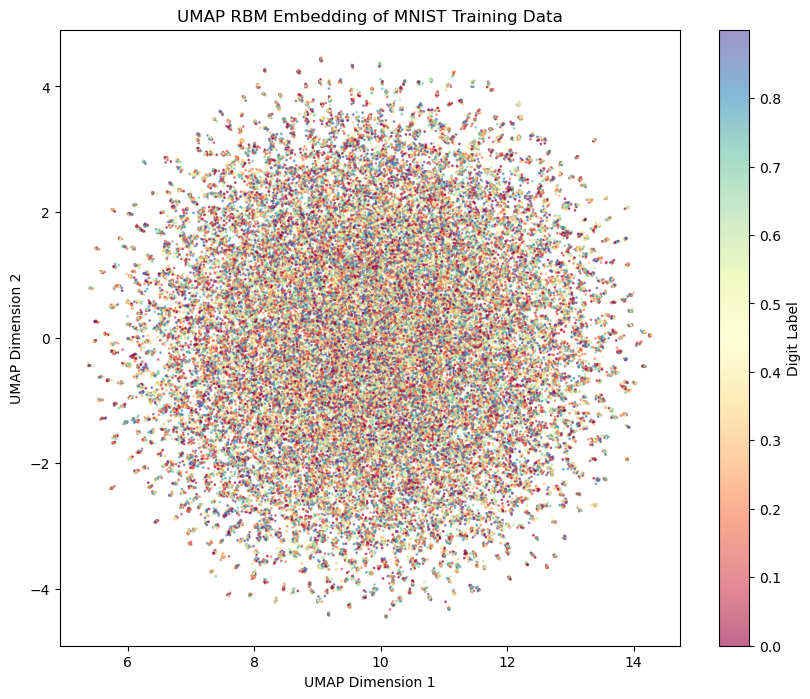

In [32]:
rbm = dbn.rbm
X_train_bin = train_x.cpu().numpy().astype(np.float64)
X_test_bin = test_x.cpu().numpy().astype(np.float64)
y_train = train_y.cpu().numpy().astype(np.float64)
y_test = test_y.cpu().numpy().astype(np.float64) 
y_train_input = y_train.reshape(-1, 1)
y_test_input = y_test.reshape(-1, 1)

# Extract embeddings (transform) for train and test sets
X_train_embedded = rbm.transform(X_train_bin, y_train_input)
X_test_embedded = rbm.transform(X_test_bin, y_test_input)

# Initialize UMAP with desired parameters
# umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap = UMAP()
# warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_embedded)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [33]:
mnist = MNIST()
train_x, train_y, test_x, test_y = mnist.load_dataset()
train_x = train_x.float()
train_y = train_y.float()
test_x = test_x.float()
test_y = test_y.float()
print('MAE for all 0 selection:', torch.mean(train_x))
batch_size = 1000	
datasize = train_x.shape[0]
data_dimension = train_x.shape[1]

print("The whole dataset has {} data. The dimension of each data is {}. Batch size is {}.".format(datasize, data_dimension, batch_size))

# train_x = train_x[:3*batch_size]
# train_y = train_y[:3*batch_size]

dataset = TensorDataset(train_x, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

MAE for all 0 selection: tensor(0.1323)
The whole dataset has 60000 data. The dimension of each data is 784. Batch size is 1000.


In [ ]:
directory = "../results/plots/DBN/debug/UMAP_multinomial_label/"
latent_dim = 500
filename = "dbn_multinomial_label_unnormalized" + str(latent_dim) + ".pth"
if not os.path.exists(directory):
    os.makedirs(directory)
dbn = DBN(data_dimension, layers=[500], batch_size=batch_size, epochs = 100000, savefile=filename, mode = "bernoulli", multinomial_top = True, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = True, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1.)
dbn.load_model(filename)
total_epoch = 110000
dbn.train(data_loader, directory)

latent_loader = dbn.encode(data_loader)
new_dir = directory + "final_latent_embedding.png"
visualize_data(latent_loader, 3, new_dir, project=False)
print("Finished dbn with latent dimension {} Experiment with {} epoches".format(latent_dim, total_epoch))

Finished Training Layer 0 to 1
Training Loss of DBN with 1 layers: 7.914676189422607
Time taken for training DBN layer 0 to 1 is 2836.5311217308044 seconds
Finished Training Layer 1 to 2
Training Loss of DBN with 2 layers: 7.935499668121338
Time taken for training DBN layer 1 to 2 is 2059.2538599967957 seconds
The last layer will not be activated. The rest are activated using the Sigmoid function.


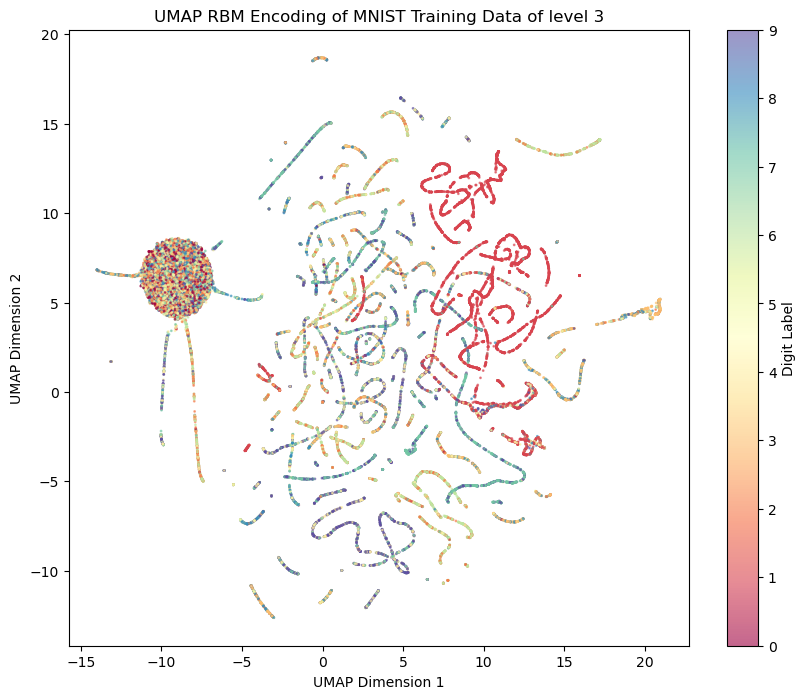

Finished dbn with latent dimension 300 Experiment with 1000 epoches


In [36]:
directory = "../results/plots/DBN/debug/UMAP_multinomial_label/"
latent_dim = 300
filename = "dbn_multinomial_label_unnormalized" + str(latent_dim) + ".pth"
if not os.path.exists(directory):
    os.makedirs(directory)
dbn = DBN(data_dimension, layers=[500, 300], batch_size=batch_size, epochs = 1000, savefile=filename, mode = "bernoulli", multinomial_top = True, multinomial_sample_size = 10, bias = False, k = 50, gaussian_top = False, top_sigma = 0.1*torch.ones((1,)), sigma = None, disc_alpha = 1.)
# dbn.load_model(filename)
total_epoch = 1000
dbn.train(data_loader, directory)

latent_loader = dbn.encode(data_loader)
new_dir = directory + "final_latent_embedding_no_label.png"
visualize_data(latent_loader, 3, new_dir, project=False)
print("Finished dbn with latent dimension {} Experiment with {} epoches".format(latent_dim, total_epoch))